In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Auxiliary functions

In [2]:
def PlotDensity(df, target_variable, numerical_feature_variable, remove_extreme_values=False):
    fig, ax = plt.subplots(figsize=(10,8))

    df_aux = df[~df[numerical_feature_variable].isna()][[target_variable, numerical_feature_variable]].copy() #remove missing
    if remove_extreme_values == True:
        value_extreme = np.quantile(df_aux[numerical_feature_variable].values, 1-0.01) #remove extreme values, because these values may harm visualization
        df_aux = df_aux[df_aux[numerical_feature_variable]<value_extreme].copy() #remove extreme values, because these values may harm visualization
    
    df_aux_1 = df_aux[df_aux[target_variable] == 1].copy() # select default group
    df_aux_0 = df_aux[df_aux[target_variable] == 0].copy() # select non default group
    
    df_aux_1.columns = [target_variable, 'Default']
    df_aux_0.columns = [target_variable, 'NonDefault']
    
    sns.kdeplot(df_aux_1['Default'], shade=True, ax=ax) #display density
    sns.kdeplot(df_aux_0['NonDefault'], shade=True, ax=ax) #display density

In [3]:
def ks(df, target_variable, score_variable):
    
    n0_total = df[df[target_variable]==0].shape[0]
    n1_total = df[df[target_variable]==1].shape[0]
    ks_value=0
    for t in df[score_variable].values:
        df_ks = df[df[score_variable]<=t].copy()

        n0 = df_ks[df_ks[target_variable]==0].shape[0]
        n1 = df_ks[df_ks[target_variable]==1].shape[0]

        p0 = n0*1.0/n0_total
        p1 = n1*1.0/n1_total
        ks_aux = abs(p0-p1)

        if ks_aux>ks_value:
            ks_value = ks_aux
            
    return ks_value

## Separating data variables in two sets
1 - target variable

2 - features variables (predictive variables)

In [4]:
target = 'SeriousDlqin2yrs'
features_variables = ['RevolvingUtilizationOfUnsecuredLines', 'age',
                      'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
                      'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
                      'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
                      'NumberOfDependents']

## Loading Data

In [5]:
df_dados = pd.read_csv('../cs-training.csv')

In [6]:
df_dados.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Fill missing Values
* Use 1 - Exploratory results

In [7]:
df_dados['MonthlyIncome'] = df_dados['MonthlyIncome'].fillna(6921.72)
df_dados['NumberOfDependents'] = df_dados['NumberOfDependents'].fillna(-1)

## Creating new features

In [8]:
df_dados['income_per_capta'] = df_dados[['MonthlyIncome', 'NumberOfDependents']].apply(lambda x: x[0]/x[1] if x[1] != 0 and x[1] != -1 else x[0], axis=1).values
df_dados['TotalNumberOfTimeDaysPastDue'] = df_dados[['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']].apply(lambda x: x[0]+x[1]+x[2], axis=1).values

In [9]:
features_variables.append('income_per_capta')
features_variables.append('TotalNumberOfTimeDaysPastDue')

## Split Train and test datasets
* 10% for test dataset

In [10]:
df_test = df_dados.sample(frac=0.1, random_state=221188, replace=False)
df_train = df_dados.drop(index=df_test.index)

In [11]:
print('Shape Train:', df_train.shape, '   ------   ', 'Shape test:', df_test.shape)

Shape Train: (135000, 14)    ------    Shape test: (15000, 14)


## Train the model
* Im using gradient boosting, this algorithm creates an ensemble of trees, the best parameters is selected using grid search and cross validation and model selection criteria is according to area under roc curve.

In [14]:
parameters_gb = params = {'n_estimators': [10, 20, 50, 100, 200, 300, 500, 700, 1000], 'max_depth': [1,2,3],
                          'min_samples_split': [30], 'learning_rate': [0.01, 0.1, 1]}

gradient_boosting = ensemble.GradientBoostingClassifier(random_state=654321)

grid_search_obj = GridSearchCV(gradient_boosting, parameters_gb, n_jobs=-1, cv=5, scoring = 'roc_auc')

grid_search_obj.fit(df_train[features_variables], df_train[target].values)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=654321),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 2, 3], 'min_samples_split': [30],
                         'n_estimators': [10, 20, 50, 100, 200, 300, 500, 700,
                                          1000]},
             scoring='roc_auc')

In [15]:
gbm_classifier = grid_search_obj.best_estimator_

In [27]:
grid_search_obj.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_split': 30,
 'n_estimators': 500}

## Feature Importance
* Features ranked by prediction importance

In [28]:
df_feats = pd.DataFrame(columns=['Features', 'VarImp'])
df_feats['Features'] = features_variables
df_feats['VarImp'] = gbm_classifier.feature_importances_
df_feats.sort_values(by= 'VarImp', inplace=True, ascending=False)
df_feats

,Features,VarImp
11,TotalNumberOfTimeDaysPastDue,0.536933
0,RevolvingUtilizationOfUnsecuredLines,0.180457
6,NumberOfTimes90DaysLate,0.180088
8,NumberOfTime60-89DaysPastDueNotWorse,0.031058
1,age,0.017083
3,DebtRatio,0.015544
5,NumberOfOpenCreditLinesAndLoans,0.011334
7,NumberRealEstateLoansOrLines,0.008867
4,MonthlyIncome,0.006742
10,income_per_capta,0.006510


## Evaluating Model - Test dataset
* Predicting default probability
* Calculating AUC
* Ploting score(probability of default) density for two groups(default and non defaul)
* Calculating KS - Kolmogorov Smirnov

In [29]:
pdct_gbm = gbm_classifier.predict_proba(df_test[features_variables])[:,1]

In [30]:
print("Area Under Roc Curve", np.round(100*roc_auc_score(df_test[target].values, pdct_gbm),2))

Area Under Roc Curve 85.77


#### Score density
* We can see the score distribution is very different between two groups(default and non defaul)

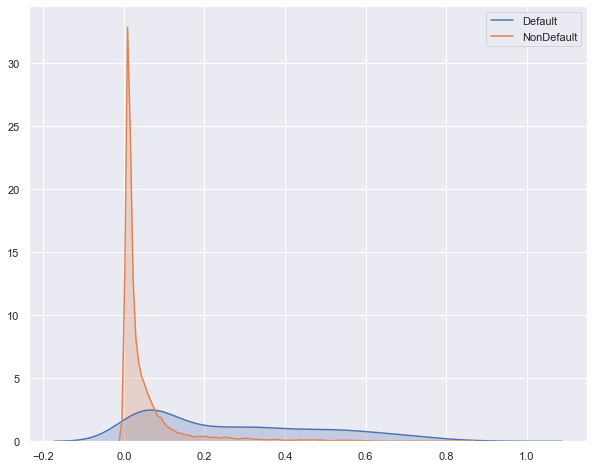

In [31]:
df_aux = pd.DataFrame(columns=[target, 'Score'])
df_aux[target] = df_test[target].values
df_aux['Score'] = pdct_gbm

PlotDensity(df_aux, target, 'Score')

#### KS Value

In [32]:
print('KS Value is:', np.round(100*ks(df_aux, target, 'Score'),2))

KS Value is: 57.04


## Saving PKL model

In [33]:
import pickle
pickle.dump(gbm_classifier, open('gradient_boosting_model.pkl', 'wb'))